In [26]:
!pip install kagglehub

In [27]:
!pip install tensorflow

In [36]:
import kagglehub
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from PIL import Image, UnidentifiedImageError
from collections import defaultdict
import os
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import hashlib

In [37]:
# Download dataset Food-101 (food41)
path = kagglehub.dataset_download("kmader/food41")

# Path ke folder utama dataset
dataset_path = os.path.join(path, "images")


In [38]:
print("Dataset disimpan di:", path)

Dataset disimpan di: /kaggle/input/food41


In [39]:
# Hitung jumlah gambar per kelas sebelum cleaning
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort kelas berdasarkan urutan abjad
sorted_class_counts = dict(sorted(class_counts.items()))

# Print Jumlah gambar per kelasnya
print("Jumlah gambar per kelas:")
for cls, count in sorted_class_counts.items():
    print(f"{cls}: {count}")

Jumlah gambar per kelas:
apple_pie: 1000
baby_back_ribs: 1000
baklava: 1000
beef_carpaccio: 1000
beef_tartare: 1000
beet_salad: 1000
beignets: 1000
bibimbap: 1000
bread_pudding: 1000
breakfast_burrito: 1000
bruschetta: 1000
caesar_salad: 1000
cannoli: 1000
caprese_salad: 1000
carrot_cake: 1000
ceviche: 1000
cheese_plate: 1000
cheesecake: 1000
chicken_curry: 1000
chicken_quesadilla: 1000
chicken_wings: 1000
chocolate_cake: 1000
chocolate_mousse: 1000
churros: 1000
clam_chowder: 1000
club_sandwich: 1000
crab_cakes: 1000
creme_brulee: 1000
croque_madame: 1000
cup_cakes: 1000
deviled_eggs: 1000
donuts: 1000
dumplings: 1000
edamame: 1000
eggs_benedict: 1000
escargots: 1000
falafel: 1000
filet_mignon: 1000
fish_and_chips: 1000
foie_gras: 1000
french_fries: 1000
french_onion_soup: 1000
french_toast: 1000
fried_calamari: 1000
fried_rice: 1000
frozen_yogurt: 1000
garlic_bread: 1000
gnocchi: 1000
greek_salad: 1000
grilled_cheese_sandwich: 1000
grilled_salmon: 1000
guacamole: 1000
gyoza: 1000
ham

In [40]:
# Inisialisasi
valid_images = []
invalid_images = []
image_sizes = defaultdict(int)

In [41]:
# Scan semua gambar di dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            # Verifikasi apakah gambar tidak rusak
            with Image.open(img_path) as img:
                img.verify()
            valid_images.append(img_path)

            # Hitung ukuran gambar
            with Image.open(img_path) as im:
                size = im.size  # (width, height)
                image_sizes[size] += 1

        except (UnidentifiedImageError, OSError):
            invalid_images.append(img_path)
            print(f"Gambar rusak: {img_path}")


In [42]:
print(f"\nTotal gambar valid  : {len(valid_images)}")
print(f"Total gambar rusak  : {len(invalid_images)}")


Total gambar valid  : 101000
Total gambar rusak  : 0


In [43]:
print(f"\nDistribusi ukuran gambar (width x height):")
for size, count in sorted(image_sizes.items(), key=lambda x: -x[1]):
    print(f"{size[0]}x{size[1]}: {count} gambar")


Distribusi ukuran gambar (width x height):
512x512: 62206 gambar
512x384: 14791 gambar
384x512: 6518 gambar
382x512: 2879 gambar
512x382: 2512 gambar
512x341: 1508 gambar
512x306: 1031 gambar
512x289: 911 gambar
512x288: 890 gambar
511x512: 543 gambar
306x512: 504 gambar
512x383: 454 gambar
512x340: 383 gambar
512x307: 371 gambar
512x342: 359 gambar
289x512: 290 gambar
512x511: 270 gambar
288x512: 255 gambar
341x512: 251 gambar
512x287: 220 gambar
383x512: 210 gambar
512x343: 183 gambar
512x339: 151 gambar
307x512: 132 gambar
512x385: 101 gambar
512x509: 85 gambar
512x308: 82 gambar
287x512: 77 gambar
510x512: 66 gambar
342x512: 52 gambar
512x500: 44 gambar
512x510: 42 gambar
512x366: 41 gambar
340x512: 40 gambar
508x512: 38 gambar
512x304: 37 gambar
308x512: 36 gambar
512x508: 35 gambar
512x410: 34 gambar
512x471: 34 gambar
512x344: 33 gambar
385x512: 33 gambar
509x512: 32 gambar
512x506: 30 gambar
512x386: 30 gambar
339x512: 29 gambar
512x381: 26 gambar
506x512: 25 gambar
343x512: 2

In [44]:
import hashlib

hashes = set()
duplicates = []

for img_path in valid_images:
    with open(img_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
    if file_hash in hashes:
        duplicates.append(img_path)
    else:
        hashes.add(file_hash)

print(f"Jumlah gambar duplikat: {len(duplicates)}")


Jumlah gambar duplikat: 8


In [46]:
# Hitung ulang jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

In [47]:
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df_counts = df_counts.sort_values("Count", ascending=False)

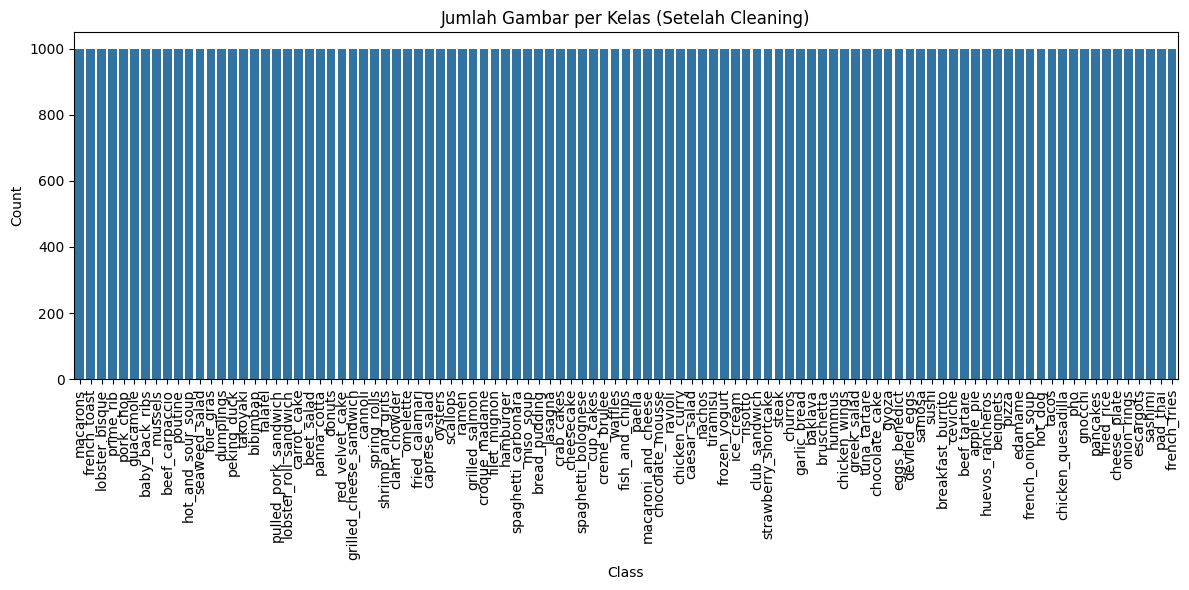

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x="Class", y="Count")
plt.xticks(rotation=90)
plt.title("Jumlah Gambar per Kelas (Setelah Cleaning)")
plt.tight_layout()
plt.show()